In [1]:
# installing packages
%pip install mne
import joblib
import matplotlib
import numpy as np
import scipy
import mne
%pip install pyEDFlib
from pyedflib import highlevel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 50.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 18.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive/MyDrive/
%ls

Mounted at /gdrive
/gdrive/MyDrive
'05_23_neuron_course (1).ipynb'   dreem91.edf
 19.04/                           dreem91.h5
 19102cd.fdt                      eeg_data.csv
 19102cd.set                      F7_O1_data.txt
 1910.edf                         fif.fif
 1910.h5                          hypnogram.txt
 anno.edf                         multitaper_spectrogram_python.py
'Colab Notebooks'/                ooo.txt
 dataFilter.fif                   __pycache__/


### import data

** import data as h5 file to mne python**

I accessed data using h5py and then put all channels signal in one matrix where the shape of it is (number-of-channels, samples). Then I create my data information and import data into MNE. 

In [3]:
import h5py
# note that in some of dreem's recording instead of 'Channel1' it is 'eeg1' 
# Open the HDF5 file
with h5py.File('1910.h5', 'r') as hf:
    f7_o1 = hf['eeg1']['raw'][:]
    f8_o2 = hf['eeg2']['raw'][:]
    fp1_f8 = hf['eeg3']['raw'][:]
    f8_f7 = hf['eeg4']['raw'][:]
    fp1_o1 = hf['eeg5']['raw'][:]
    fp1_o2 = hf['eeg6']['raw'][:]
    fp1_f7 = hf['eeg7']['raw'][:]
data = np.vstack([f7_o1, f8_o2, fp1_f8, f8_f7, fp1_o1, fp1_o2, fp1_f7])
# Create an MNE info object
ch_names = ['F7_O1', 'F8_O2', 'Fp1_F8', 'F8_F7', 'Fp1_O1', 'Fp1_O2', 'Fp1_F7']
ch_types = ['eeg'] * len(ch_names)
sfreq = 250
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
 #Create an MNE RawArray object for the concatenated data
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=7, n_times=8408209
    Range : 0 ... 8408208 =      0.000 ... 33632.832 secs
Ready.


###Filtering the data

In [4]:
# Filter settings
low_cut = 0.4
hi_cut  = 35
#function
dataFilter = raw.filter(low_cut,hi_cut)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.4 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.40
- Lower transition bandwidth: 0.40 Hz (-6 dB cutoff frequency: 0.20 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 2063 samples (8.252 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.0s finished


### extract the time points for each stage periods

In [6]:
import pandas as pd
print('''
0= wake
1=N1
2=N2
3=N3
4=REM
''')
# Read data from file
data = pd.read_csv('hypnogram.txt', header=None, sep='\t')

# Define mapping of old values to new values
oldvalues = ['SLEEP-S0', 'SLEEP-REM', 'SLEEP-S1', 'SLEEP-S2', 'SLEEP-S3', 'SLEEP-MT']
newvalues = ['0', '4', '1', '2', '3', '5']

# Replace old values with new values
data[0] = data[0].replace(oldvalues, newvalues)

# Convert the data type of the first column to integer
data[0] = data[0].astype(int)

# Get the sampling frequency
fs = 1/30  # 30 seconds per sample

# Loop over each sleep stage and extract the periods
for stage in range(6):
    # Get the indices where the sleep stage is equal to the current stage
    indices = data.index[data[0] == stage]
    
    # If there are no periods for this stage, continue to the next stage
    if len(indices) == 0:
        continue
    
    # Initialize the start and end times of the first period
    start_time = indices[0] * 30
    end_time = start_time
    
    # Loop over the remaining indices and extract the periods
    for i in range(1, len(indices)):
        # If the current index is consecutive to the previous index, update the end time
        if indices[i] == indices[i-1]+1:
            end_time = indices[i] * 30
        # Otherwise, print the start and end times of the previous period and update the start time
        else:
            print(f"Sleep stage {stage} from {start_time:.1f}s to {end_time:.1f}s")
            start_time = indices[i] * 30
            end_time = start_time
            
    # Print the start and end times of the last period
    print(f"Sleep stage {stage} from {start_time:.1f}s to {end_time:.1f}s")



0= wake
1=N1
2=N2
3=N3
4=REM

Sleep stage 0 from 0.0s to 1050.0s
Sleep stage 0 from 3960.0s to 3960.0s
Sleep stage 0 from 7410.0s to 7410.0s
Sleep stage 0 from 7950.0s to 7980.0s
Sleep stage 0 from 8970.0s to 9030.0s
Sleep stage 0 from 9270.0s to 9270.0s
Sleep stage 0 from 9750.0s to 9750.0s
Sleep stage 0 from 9840.0s to 9840.0s
Sleep stage 0 from 12420.0s to 12420.0s
Sleep stage 0 from 13590.0s to 13620.0s
Sleep stage 0 from 14580.0s to 14580.0s
Sleep stage 0 from 14640.0s to 14640.0s
Sleep stage 0 from 18060.0s to 18060.0s
Sleep stage 0 from 19260.0s to 19260.0s
Sleep stage 0 from 20010.0s to 20010.0s
Sleep stage 0 from 20670.0s to 20670.0s
Sleep stage 0 from 21510.0s to 21510.0s
Sleep stage 0 from 24150.0s to 24150.0s
Sleep stage 0 from 24960.0s to 24960.0s
Sleep stage 0 from 25020.0s to 25020.0s
Sleep stage 0 from 26820.0s to 26820.0s
Sleep stage 0 from 28560.0s to 28560.0s
Sleep stage 0 from 28680.0s to 28680.0s
Sleep stage 0 from 31380.0s to 31380.0s
Sleep stage 0 from 32490.0s 

### Get data for each channel as a numpy array in 1D

**extraxting channels using MNE**

In [7]:

# you can add  tmin and tmax to get the data for part of recording
#channelName_data = raw.get_data(picks= 0, tmin= t1, tmax=t2)
F7_O1_data=dataFilter.get_data(picks=0)
F8_O2_data=dataFilter.get_data(picks=1)
Fp1_F8_data= dataFilter.get_data(picks=2)
F8_F7_data= dataFilter.get_data(picks=3)
Fp1_O1_data= dataFilter.get_data(picks=4)
Fp1_O2_data= dataFilter.get_data(picks=5)
Fp1_F7_data= dataFilter.get_data(picks=6)

### Creat hypnogram graph

Note that you have to delete first lines of hypnogram that is about total sleep and etc.

whole night

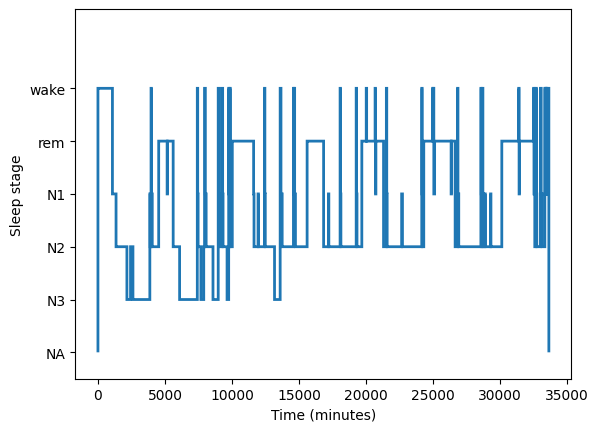

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from file
data = pd.read_table('hypnogram.txt', header=None)
oldvalues = ['SLEEP-S0', 'SLEEP-REM', 'SLEEP-S1', 'SLEEP-S2', 'SLEEP-S3', 'SLEEP-MT']
newvalues = ['5', '4', '3', '2', '1', '0']
data[0] = data[0].replace(oldvalues, newvalues)
hypno = data[0]
stage_data = np.repeat(hypno, 30)
fs = 0.0333  # Sampling rate in Hz
t = np.arange(len(hypno))/fs
stage_data_num = stage_data.astype(int)
plt.stairs(stage_data_num, linewidth=2)
# Set the y-axis limits to show the different sleep stages
plt.ylim([-0.5, 6.5])
# Label the y-axis with the different sleep stages
plt.yticks([0, 1, 2, 3, 4, 5], ['NA', 'N3', 'N2', 'N1', 'rem', 'wake'])
plt.ylabel('Sleep stage')
# Label the x-axis with the time
plt.xlabel('Time (minutes)')
plt.show()

first cycle

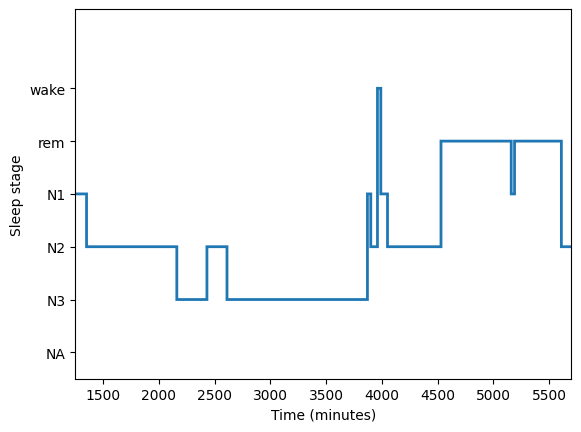

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read data from file
data = pd.read_table('hypnogram.txt', header=None)
oldvalues = ['SLEEP-S0', 'SLEEP-REM', 'SLEEP-S1', 'SLEEP-S2', 'SLEEP-S3', 'SLEEP-MT']
newvalues = ['5', '4', '3', '2', '1', '0']
data[0] = data[0].replace(oldvalues, newvalues)
hypno = data[0]
stage_data = np.repeat(hypno, 30)
fs = 0.0333  # Sampling rate in Hz
t = np.arange(len(hypno))/fs
stage_data_num = stage_data.astype(int)
plt.stairs(stage_data_num, linewidth=2)
# Set the y/x-axis limits to show the different sleep stages
plt.ylim([-0.5, 6.5])
plt.xlim([1250,5700])
# Label the y-axis with the different sleep stages
plt.yticks([0, 1, 2, 3, 4, 5], ['NA', 'N3', 'N2', 'N1', 'rem', 'wake'])
plt.ylabel('Sleep stage')
# Label the x-axis with the time
plt.xlabel('Time (minutes)')
plt.show()

# processing

you have to download multitaper_spectrogram_python file and add it to your cirtual enviroment if you use google colab upload it to your google drive. be carfule the the name of python file should be the same as multitaper_spectrogram_python; you can change the name but do not forget to change the name in the fist line of code in next section 

In [8]:
from multitaper_spectrogram_python import multitaper_spectrogram  # import multitaper_spectrogram function from the multitaper_spectrogram_python.py file

Multitaper Spectrogram Properties: 
     Spectral Resolution: 1.0Hz
     Window Length: 30.0s
     Window Step: 5.0s
     Time Half-Bandwidth Product: 15
     Number of Tapers: 29
     Frequency Range: 0-25Hz
     NFFT: 8192
     Detrend: constant


 Multitaper compute time: 244.40 seconds


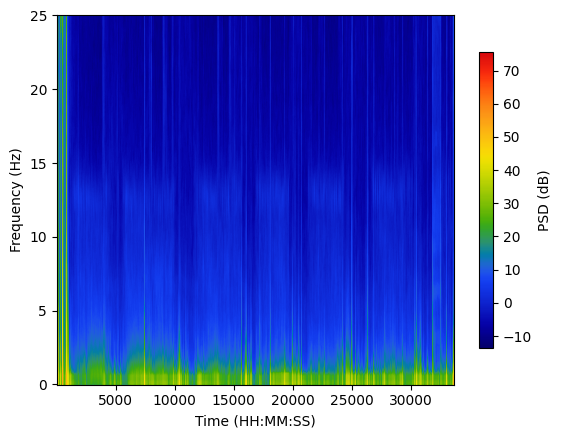

In [ ]:

# Set spectrogram params for whole night 
fs=250
frequency_range = [0, 25]  # Limit frequencies from 0 to 25 Hz
time_bandwidth = 15  # Set time-half bandwidth
num_tapers = 29  # Set number of tapers (optimal is time_bandwidth*2 - 1)
window_params = [30,5]  # Window size is 30s with step size of 5s
min_nfft = 0  # No minimum nfft
detrend_opt = 'constant'  # detrend each window by subtracting the average
multiprocess = True  # use multiprocessing
cpus = 1  # use 1 cores in multiprocessing
weighting = 'unity'  # weight each taper at 1
plot_on = True  # plot spectrogram
return_fig = False  # do not return plotted spectrogram
clim_scale = False  # do not auto-scale colormap
verbose = True  # print extra info
xyflip = False  # do not transpose spect output matrix
#Channel 4
spect, stimes, sfreqs = multitaper_spectrogram(F8_F7_data, fs, frequency_range, time_bandwidth, num_tapers, window_params, min_nfft, detrend_opt, multiprocess, cpus,
                                               weighting, plot_on, return_fig, clim_scale, verbose, xyflip)

In [9]:
from multitaper_spectrogram_python import multitaper_spectrogram  # import multitaper_spectrogram function from the multitaper_spectrogram_python.py file

In [10]:
# Set spectrogram params for ultradian scale
fs=250
frequency_range = [0, 25]  # Limit frequencies from 0 to 25 Hz
time_bandwidth = 4.5  # Set time-half bandwidth
num_tapers = 8  # Set number of tapers (optimal is time_bandwidth*2 - 1)
window_params = [6,0.248]  # Window size is 6s with step size of 0.25s
min_nfft = 0  # No minimum nfft
detrend_opt = 'constant'  # detrend each window by subtracting the average
multiprocess = True  # use multiprocessing
cpus = 1  # use 1 cores in multiprocessing
weighting = 'unity'  # weight each taper at 1
plot_on = True  # plot spectrogram
return_fig = False  # do not return plotted spectrogram
clim_scale = False  # do not auto-scale colormap
verbose = True  # print extra info
xyflip = False  # do not transpose spect output matrix


In [17]:
F8_F7_data_croped= dataFilter.get_data(picks=3, tmin=1250 , tmax=5700 )

Multitaper Spectrogram Properties: 
     Spectral Resolution: 1.5Hz
     Window Length: 6.0s
     Window Step: 0.248s
     Time Half-Bandwidth Product: 4.5
     Number of Tapers: 8
     Frequency Range: 0-25Hz
     NFFT: 2048
     Detrend: constant


 Multitaper compute time: 69.60 seconds


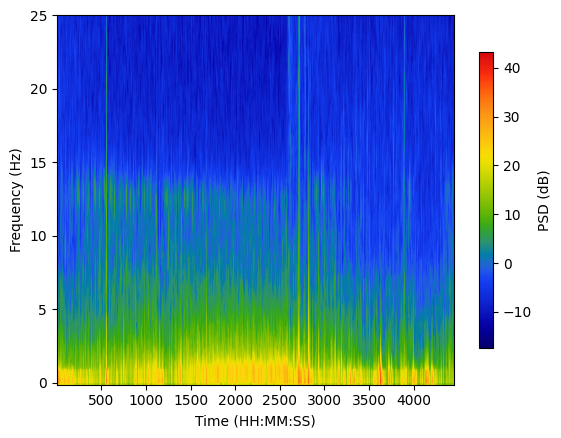

In [18]:
spect, stimes, sfreqs = multitaper_spectrogram(F8_F7_data_croped, fs, frequency_range, time_bandwidth, num_tapers, window_params, min_nfft, detrend_opt, multiprocess, cpus,
                                               weighting, plot_on, return_fig, clim_scale, verbose, xyflip)